In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import alexnet
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [2]:
mpl.rcParams['figure.dpi'] = 300
sns.set_theme()
sns.set_style("ticks")

## Setup

In [18]:
# Define the Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the Custom Dataset Class
class CrosswayDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 0]) + '.jpg')
        image = Image.open(img_name).convert('RGB')
        label = int(self.dataframe.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch']
    return start_epoch

In [19]:
df_platform_path  = 'df_platform.csv'
distort_img_path = 'distorted_platform_images_uncrop'
df_platform_full = pd.read_csv(df_platform_path)
df_platform = df_platform_full[["id2","level"]]
platform_dataset = CrosswayDataset(dataframe=df_platform, root_dir=distort_img_path, transform=transform)
platform_loader = DataLoader(platform_dataset, batch_size=32, shuffle=False)
df_platform

,id2,level
0,2000000,0
1,2000001,1
2,2000002,2
3,2000003,3
4,2000004,4
...,...,...
985,2000985,94
986,2000986,95
987,2000987,96
988,2000988,97


# Inference

In [20]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the pretrained AlexNet model
model = alexnet(pretrained=True)

# Modify the classifier to output 18 classes
model.classifier[-1] = nn.Linear(in_features=4096, out_features=99)

# Load the model weights
model_path = 'AlexNet_cuda_weights/classi/alexnet_classi_epoch_21.pth'  ############# Select your trained model weights
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

Using device: cuda


/usr/local/lib64/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib64/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Testing on 1 image

In [21]:
torch.cuda.empty_cache()

In [22]:
df_test = df_platform
df_test_full = df_platform_full

In [23]:
# Define the image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to perform inference and get probabilities
def predict_image(image_path, model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        probabilities = torch.round(probabilities * 100) / 100  # Round to two decimal places
        predicted_class = torch.argmax(probabilities, dim=1)

    return predicted_class.item(), probabilities.cpu().numpy().flatten()

In [25]:
# Path to the image you want to infer
test_img_path = os.path.join(distort_img_path, str(df_test.iloc[0, 0]) + '.jpg')

# Perform inference
predicted_class, probabilities = predict_image(test_img_path, model, transform, device)

# Print the predicted class and probabilities
print(f'Ground truth class: {df_test.iloc[0,1]}')
print(f'Predicted class: {predicted_class}')

Ground truth class: 0
Predicted class: 0


## Testing on `test_loader`

### Predicted levels, Predicted k, Percentage error

In [26]:
test_loader = platform_loader

In [27]:
# Given array
k_list = np.linspace(1e-6, 1e-4, 100)

# Initialize a list to store the averages
k_mean = []

# Loop through the array starting from the second element
for i in range(1, len(k_list)):
    mean = (k_list[i] + k_list[i-1]) / 2
    k_mean.append(mean)

# Convert the list to a numpy array (optional)
k_mean = np.array(k_mean)

print(k_mean)

[1.50e-06 2.50e-06 3.50e-06 4.50e-06 5.50e-06 6.50e-06 7.50e-06 8.50e-06
 9.50e-06 1.05e-05 1.15e-05 1.25e-05 1.35e-05 1.45e-05 1.55e-05 1.65e-05
 1.75e-05 1.85e-05 1.95e-05 2.05e-05 2.15e-05 2.25e-05 2.35e-05 2.45e-05
 2.55e-05 2.65e-05 2.75e-05 2.85e-05 2.95e-05 3.05e-05 3.15e-05 3.25e-05
 3.35e-05 3.45e-05 3.55e-05 3.65e-05 3.75e-05 3.85e-05 3.95e-05 4.05e-05
 4.15e-05 4.25e-05 4.35e-05 4.45e-05 4.55e-05 4.65e-05 4.75e-05 4.85e-05
 4.95e-05 5.05e-05 5.15e-05 5.25e-05 5.35e-05 5.45e-05 5.55e-05 5.65e-05
 5.75e-05 5.85e-05 5.95e-05 6.05e-05 6.15e-05 6.25e-05 6.35e-05 6.45e-05
 6.55e-05 6.65e-05 6.75e-05 6.85e-05 6.95e-05 7.05e-05 7.15e-05 7.25e-05
 7.35e-05 7.45e-05 7.55e-05 7.65e-05 7.75e-05 7.85e-05 7.95e-05 8.05e-05
 8.15e-05 8.25e-05 8.35e-05 8.45e-05 8.55e-05 8.65e-05 8.75e-05 8.85e-05
 8.95e-05 9.05e-05 9.15e-05 9.25e-05 9.35e-05 9.45e-05 9.55e-05 9.65e-05
 9.75e-05 9.85e-05 9.95e-05]


In [28]:
# Assuming the model is already loaded and test_dataset is defined
model.eval()

# Initialize lists to store true labels, predictions, and k predictions
all_labels = []
all_preds = []
all_k_preds = []

# Inference on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        
        # Compute probabilities using softmax
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

        # Predict class with max probability
        _, preds = torch.max(outputs, 1)

        # Compute k_predictions using np.dot(k_mean, probabilities) for each image
        k_preds = np.dot(probabilities, k_mean)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_k_preds.extend(k_preds)

print("Done")

In [29]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_k_preds = np.array(all_k_preds)

In [30]:
df_test_report = df_test.copy(deep=True)
df_test_report["level_preds"] = all_preds
df_test_report["k_gt"] = df_test_full["k"]
df_test_report["k_preds"] = all_k_preds
df_test_report

,id2,level,level_preds,k_gt,k_preds
0,2000000,0,0,0.000001,0.000002
1,2000001,1,1,0.000003,0.000002
2,2000002,2,1,0.000003,0.000003
3,2000003,3,3,0.000004,0.000004
4,2000004,4,4,0.000005,0.000006
...,...,...,...,...,...
985,2000985,94,0,0.000095,0.000002
986,2000986,95,0,0.000096,0.000002
987,2000987,96,0,0.000097,0.000002
988,2000988,97,0,0.000099,0.000002


In [31]:
# Assuming your DataFrame is named 'df'
# Calculate the percentage error for each row
df_test_report['percentage_error'] = 100 * abs(df_test_report['k_gt'] - df_test_report['k_preds']) / df_test_report['k_gt']

# Compute the average percentage error across all rows
average_percentage_error = df_test_report['percentage_error'].mean()

print("average_percentage_error =", average_percentage_error)

df_test_report

average_percentage_error = 82.59274026893736


,id2,level,level_preds,k_gt,k_preds,percentage_error
0,2000000,0,0,0.000001,0.000002,72.318146
1,2000001,1,1,0.000003,0.000002,14.755868
2,2000002,2,1,0.000003,0.000003,15.551514
3,2000003,3,3,0.000004,0.000004,2.266885
4,2000004,4,4,0.000005,0.000006,12.721532
...,...,...,...,...,...,...
985,2000985,94,0,0.000095,0.000002,98.216149
986,2000986,95,0,0.000096,0.000002,98.249790
987,2000987,96,0,0.000097,0.000002,98.227096
988,2000988,97,0,0.000099,0.000002,98.316004


In [15]:
max_index = df_test_report["percentage_error"].idxmax()
max_row = df_test_report.loc[max_index]

print("The row with the maximum value in the column is:")
print(max_row)

The row with the maximum value in the column is:
id2                 2.000693e+06
level               0.000000e+00
level_preds         2.000000e+00
k_gt                1.432905e-06
k_preds             3.690912e-06
percentage_error    1.575824e+02
Name: 693, dtype: float64


### Classification Report, Confusion Matrix

In [16]:
# Generate the classification report
class_report = classification_report(all_labels, all_preds, digits=4)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0     0.2222    0.6000    0.3243        10
           1     0.1429    0.2000    0.1667        10
           2     0.2000    0.2000    0.2000        10
           3     0.0690    0.2000    0.1026        10
           4     0.1667    0.1000    0.1250        10
           5     0.0909    0.1000    0.0952        10
           6     0.0690    0.2000    0.1026        10
           7     0.0000    0.0000    0.0000        10
           8     0.0000    0.0000    0.0000        10
           9     0.0000    0.0000    0.0000        10
          10     0.0000    0.0000    0.0000        10
          11     0.0476    0.1000    0.0645        10
          12     0.0000    0.0000    0.0000        10
          13     0.0909    0.1000    0.0952        10
          14     0.0000    0.0000    0.0000        10
          15     0.2000    0.1000    0.1333        10
          16     0.0000    0.0000    0.0000        10
    

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


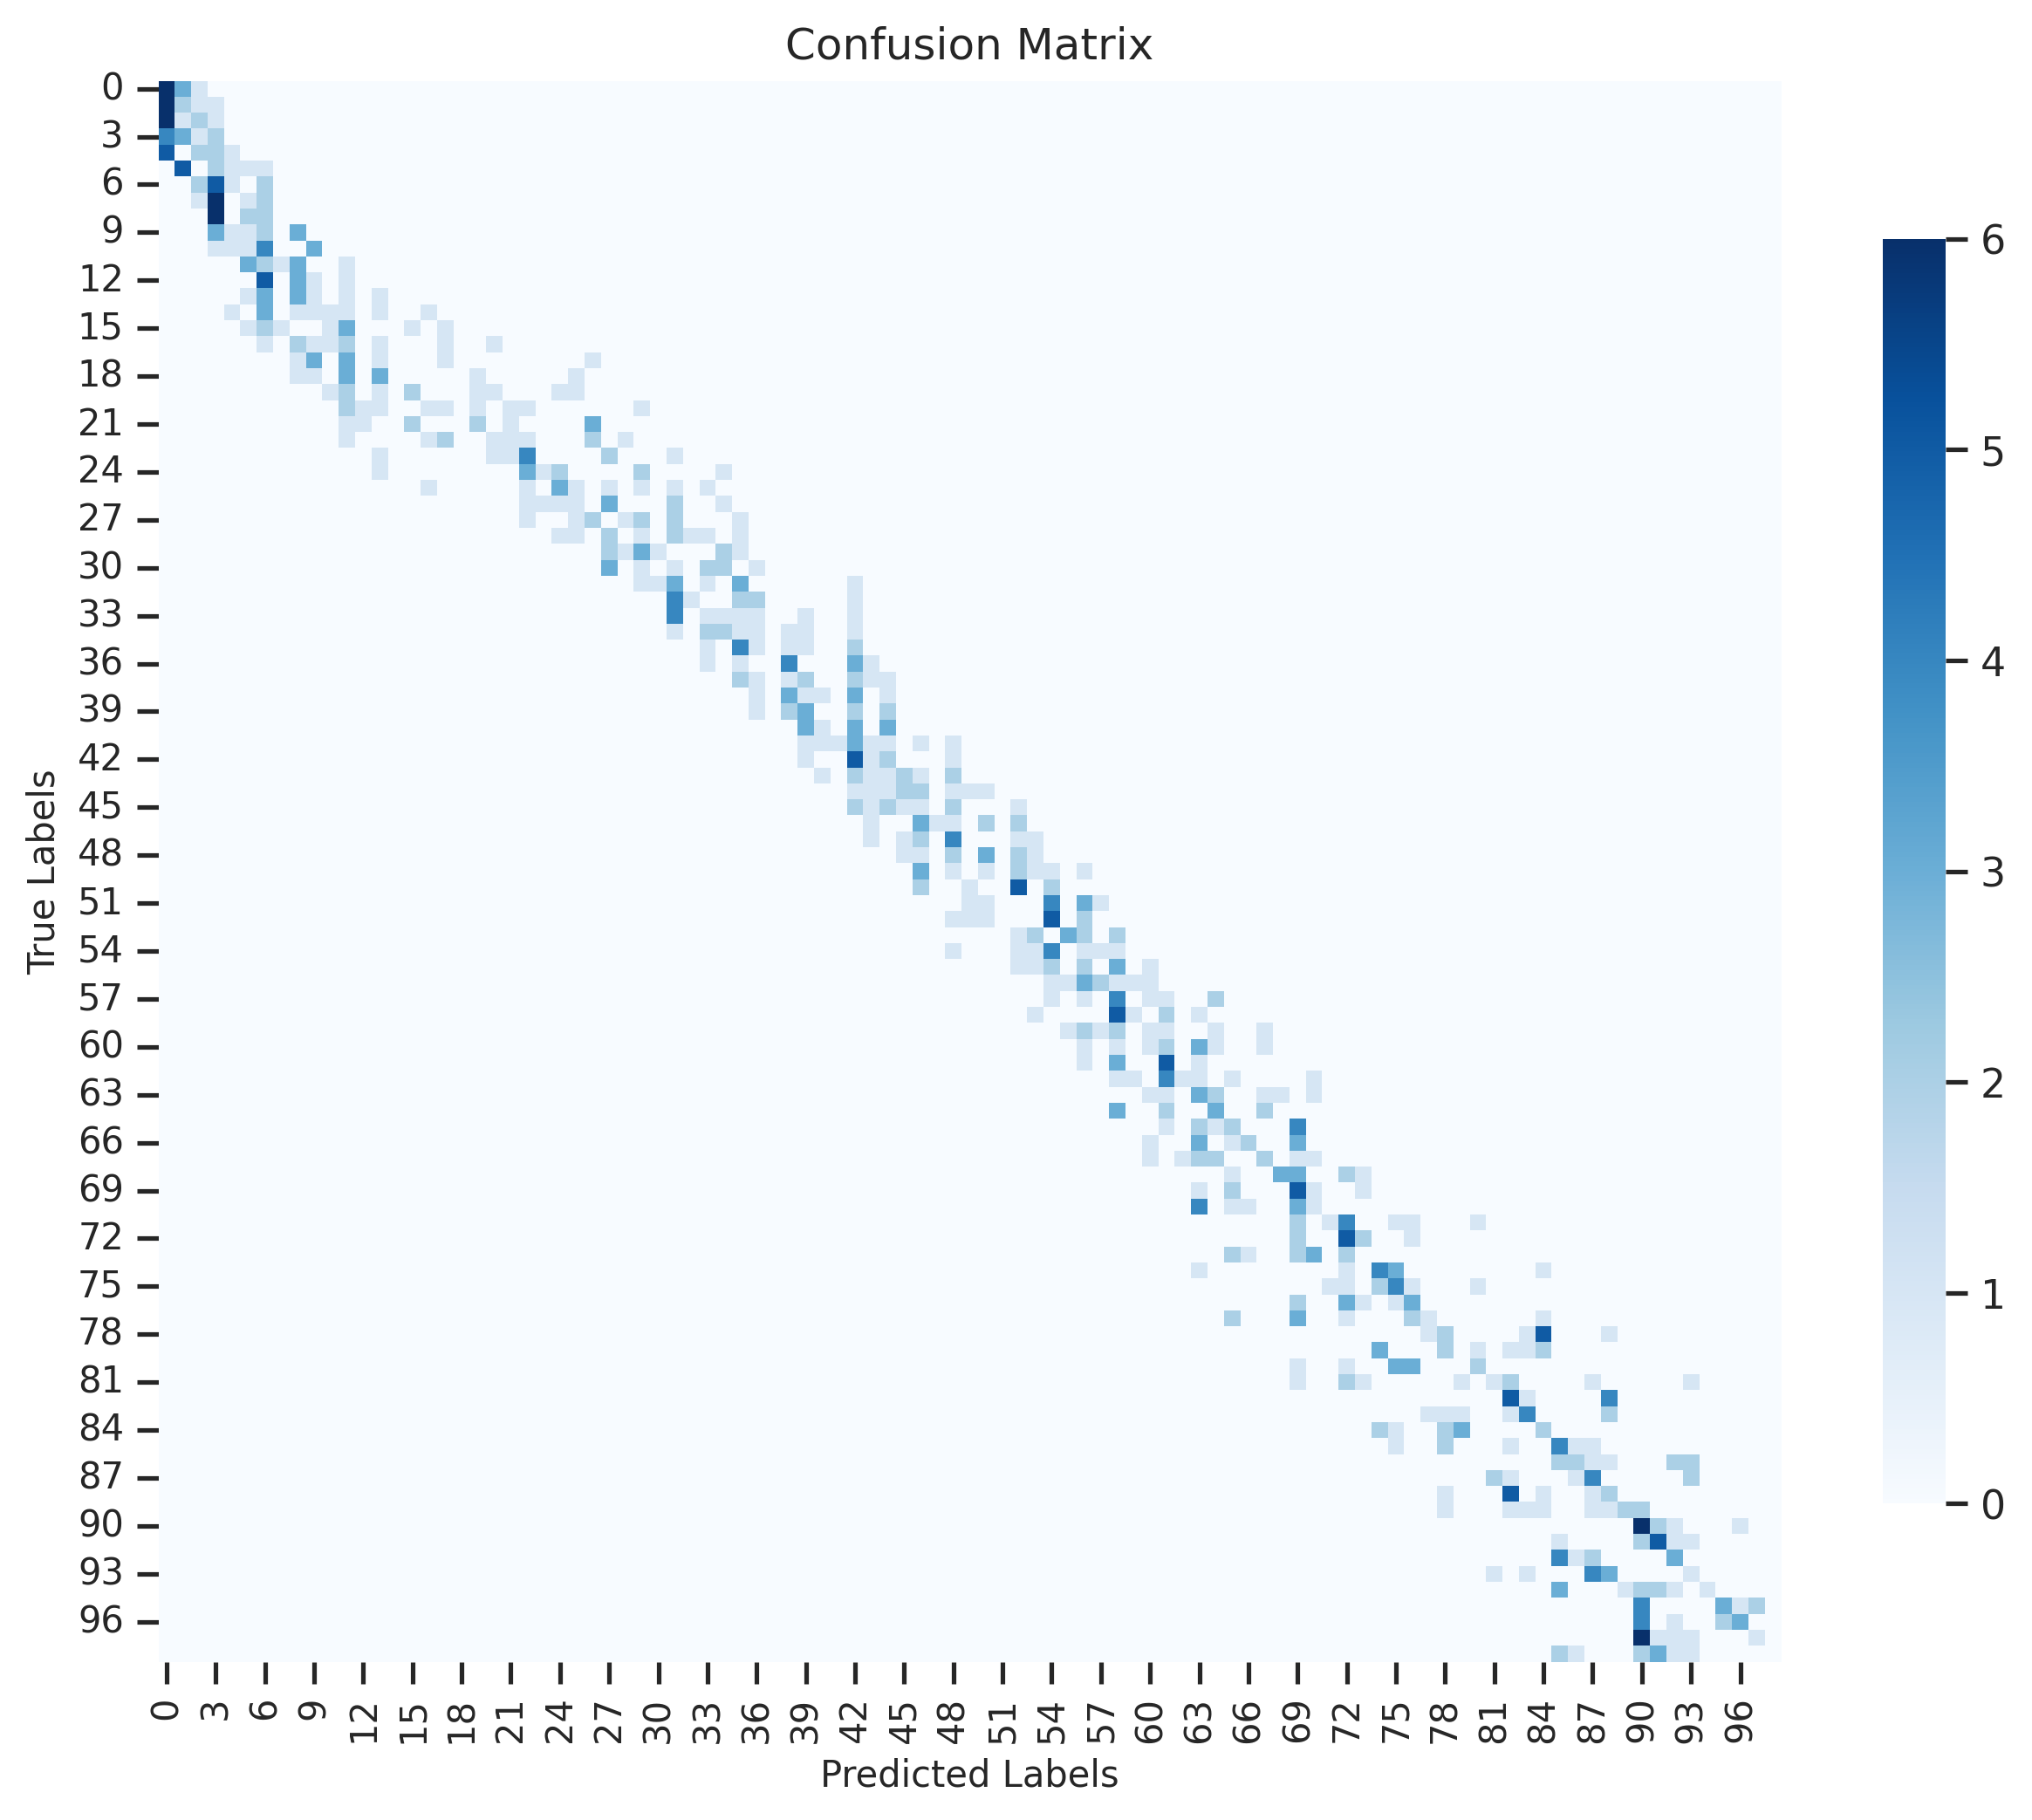

In [17]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)


# Plot the confusion matrix
plt.figure(figsize=(10, 8))

# Create the heatmap with no annotations and add color bar on the right
sns.heatmap(conf_matrix, annot=False, cmap='Blues', cbar=True, cbar_kws={"shrink": 0.8})

# Set the title and labels with reduced font sizes
plt.title('Confusion Matrix', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=10)
plt.ylabel('True Labels', fontsize=10)

# Ensure tick labels are visible with reduced font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()